In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import category_encoders as ce
# https://www.kaggle.com/discdiver/category-encoders-examples

In [4]:
from xgboost import XGBClassifier

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [7]:
from sklearn.metrics import classification_report

In [8]:
from datetime import datetime

In [161]:
from sklearn.inspection import plot_partial_dependence

In [9]:
from src.features import build_features

## Reading training data

In [10]:
data = pd.read_csv('../data/raw/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Goldsmith, Mr. Frank John",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
# discard Name and PassengerId
data = data.loc[:, ~data.columns.isin(['Name','PassengerId'])]

In [52]:
data['FamilySize']=data['SibSp']+data['Parch']

In [58]:
data['Fare_Per_Person']=data['Fare']/(data['FamilySize']+1)

In [59]:
# Selecting features and label
X = data.loc[:,~data.columns.isin(['Survived'])]
y = data.Survived

In [60]:
# selecting columns to apply "one-hot encoding"
one_hot_columns = (X.select_dtypes(include=['object']).nunique() < 10)[lambda df: df==True].index.values
one_hot_columns

array(['Sex', 'Embarked'], dtype=object)

In [61]:
# selecting column to apply label-encoding
encoding_columns =  (X.select_dtypes(include=['object']).nunique() > 10)[lambda df: df==True].index.values
encoding_columns

array(['Ticket', 'Cabin'], dtype=object)

In [62]:
# selecting numeric columns
numeric_columns = (X.select_dtypes(exclude=['object'])).columns.values
numeric_columns

array(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'Fare_Per_Person'], dtype=object)

___
## Preprocessing tasks

In [65]:
onehot_encoder = ce.OneHotEncoder(cols=one_hot_columns)
onehot_encoder.fit(X,y)

OneHotEncoder(cols=['Sex', 'Embarked'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', return_df=True,
              use_cat_names=False, verbose=0)

In [66]:
X = onehot_encoder.transform(X)

In [67]:
X.columns

Index(['Pclass', 'Sex_1', 'Sex_2', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked_1', 'Embarked_2', 'Embarked_3', 'Embarked_4',
       'FamilySize', 'Fare_Per_Person'],
      dtype='object')

In [68]:
encoder = ce.TargetEncoder(cols=encoding_columns)
encoder.fit(X,y)

TargetEncoder(cols=['Ticket', 'Cabin'], drop_invariant=False,
              handle_missing='value', handle_unknown='value',
              min_samples_leaf=1, return_df=True, smoothing=1.0, verbose=0)

In [69]:
X = encoder.transform(X)

In [70]:
from sklearn.impute import SimpleImputer

In [71]:
imputer = SimpleImputer()
imputer.fit(X.Age.values.reshape(-1,1))

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [72]:
X.Age = imputer.transform(X.Age.values.reshape(-1,1))

In [73]:
X.to_csv('../data/processed/features.csv', index=False)

In [74]:
y.to_csv('../data/processed/labels.csv', index=False)

___
### FineTuning Parameters

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [135]:
# X.Cabin
# RandomForestClassifier().get_params()

In [185]:
rf_params = {
#     'bootstrap': True,
    'ccp_alpha': 0.0,
#     'class_weight': None,
    'criterion': 'gini',
#     'max_depth': None,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'max_samples': None,
#     'min_impurity_decrease': 0.0,
    'min_impurity_split': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
#     'n_estimators': 100,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False
}

distributions = {
    "bootstrap": [True, False],
    'n_estimators': [750,1000,1250,1500],
    'class_weight': ['balanced', None], 
    'min_impurity_decrease': np.linspace(0.01,0.07),
    'max_depth': np.append(np.linspace(6,13,7, dtype = "int"), None),
    'min_samples_split': [2,4],
}

clf = RandomizedSearchCV(RandomForestClassifier(**rf_params), distributions, random_state=42, return_train_score=True)
search = clf.fit(X_train, y_train)

<BarContainer object of 15 artists>

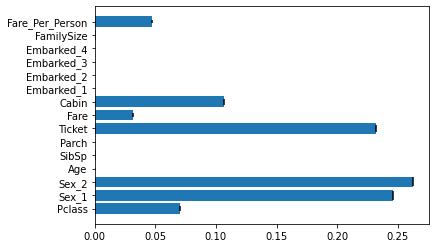

In [186]:
std = np.std([tree.feature_importances_ for tree in search.best_estimator_],axis=0)
plt.barh(X.columns,  search.best_estimator_.feature_importances_, yerr=std)

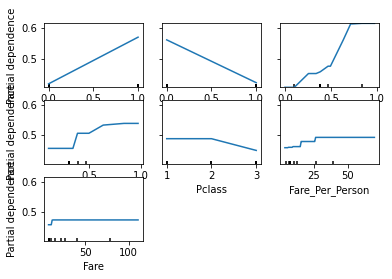

In [188]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
features_ix = search.best_estimator_.feature_importances_.argsort()[::-1][:7]

disp1 = plot_partial_dependence(
    search.best_estimator_, 
    X_train, 
    features=X_train.columns[features_ix])


In [189]:
search.best_params_

{'n_estimators': 1250,
 'min_samples_split': 4,
 'min_impurity_decrease': 0.01979591836734694,
 'max_depth': 8,
 'class_weight': 'balanced',
 'bootstrap': False}

In [190]:
print(classification_report(y_test, search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       110
           1       0.93      0.80      0.86        69

    accuracy                           0.90       179
   macro avg       0.91      0.88      0.89       179
weighted avg       0.90      0.90      0.90       179



In [191]:
# xgb_params = {
#     "eta": 0.1,
#     "max_depth": 7,
#     "gamma": 1,
#     "min_child_weight": 1,
#     "subsample": 0.5,
#     "colsample_bytree": 0.8,
#     "max_bin": 256,
#     "objective": "binary:logistic",
#     "tree_method": "hist",
#     "silent": 1,
# }

# model = XGBClassifier(**xgb_params)
# model.fit(X,y)

In [192]:
params = {
    **rf_params, **search.best_params_
}

In [193]:
model = RandomForestClassifier(**params)
model.fit(X,y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.01979591836734694,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=1250, n_jobs=4, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [194]:
y_pred = model.predict(X)

In [195]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       549
           1       0.84      0.80      0.82       342

    accuracy                           0.86       891
   macro avg       0.86      0.85      0.85       891
weighted avg       0.86      0.86      0.86       891



____

In [196]:
test = pd.read_csv('../data/raw/test.csv')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [197]:
test_prepro = test.loc[:, ~test.columns.isin(["PassengerId", "Name"])]

In [198]:
test_prepro['FamilySize']=test_prepro['SibSp']+test_prepro['Parch']

/home/jloscalzo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [199]:
# test has nan's in Fare feature
test_prepro.Fare.fillna(test_prepro.Fare.mean(), inplace=True)

test_prepro['Fare_Per_Person']=test_prepro['Fare']/(test_prepro['FamilySize']+1)

/home/jloscalzo/.local/lib/python3.6/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [200]:
test_prepro = onehot_encoder.transform(test_prepro)
test_prepro = encoder.transform(test_prepro)

In [201]:
test_prepro.Age = imputer.transform(test_prepro.Age.values.reshape(-1,1))

In [202]:
result = model.predict(test_prepro)
result

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [203]:
result = pd.Series(result, name='Survived')

In [204]:
result.index = test.PassengerId
result.index.name = 'PassengerId'

In [205]:
now = datetime.now().strftime("%Y%m%d_%H%M%S")
result.to_csv(f'../data/results/results-{now}.csv')

In [206]:
params

{'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False,
 'n_estimators': 1250,
 'min_impurity_decrease': 0.01979591836734694,
 'max_depth': 8,
 'class_weight': 'balanced',
 'bootstrap': False}

In [208]:
from joblib import dump, load
dump(model, f'../data/model/rf-{now}.joblib') 

['../data/model/rf-20200522_202744.joblib']